# Pangenome Analysis: KHV Thermal Adaptation Study

## Overview
Comparison of Minigraph-Cactus vs PGGB for Koi Herpes Virus pangenome construction.

**Dataset**: KHV genomes (p15 vs p90) - thermal shock adaptation study  
**Goal**: Identify genetic variants associated with thermal adaptation

## Methods
- **Minigraph-Cactus**: Progressive alignment approach
- **PGGB**: All-to-all alignment with graph optimization

## Workflow
1. Quality control and validation
2. Pangenome construction (both methods)
3. Variant calling and analysis
4. Comparative evaluation
5. Biological interpretation

In [35]:
# Import required libraries
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from datetime import datetime
import numpy as np

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create timestamp for this analysis
analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Analysis started at: {analysis_timestamp}")

# Function to validate file paths and directory structure
def validate_paths():
    """Validate that all file paths and directories are correctly set up"""
    
    print("\nValidating file paths and directory structure...")
    
    # Expected directories
    expected_dirs = [
        "results",
        "results/minigraph_cactus",
        "results/pggb", 
        "results/vcf_comparison",
        "results/plots",
        "results/reports",
        "data"
    ]
    
    # Check/create directories
    for directory in expected_dirs:
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
            print(f"Created directory: {directory}")
        else:
            print(f"Directory exists: {directory}")
    
    print("Path validation completed!")
    return True

# Run path validation
validate_paths()

Analysis started at: 20251001_122028

Validating file paths and directory structure...
Created directory: results
Created directory: results/minigraph_cactus
Created directory: results/pggb
Created directory: results/vcf_comparison
Created directory: results/plots
Created directory: results/reports
Directory exists: data
Path validation completed!


True

In [36]:
# Create directory structure for the analysis
def ensure_directory_structure():
    """Ensure all necessary directories exist"""
    directories = [
        "results",
        "results/minigraph_cactus",
        "results/minigraph_cactus/output", 
        "results/minigraph_cactus/tmp",
        "results/pggb",
        "results/pggb/output",
        "results/vcf_comparison",
        "results/plots",
        "results/reports",
        "results/quast_analysis",
        "data"
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    return directories

# Create all necessary directories
created_dirs = ensure_directory_structure()

print("Directory structure created:")
for root, dirs, files in os.walk("results"):
    level = root.replace("results", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for file in files[:5]:  # Show only first 5 files to avoid clutter
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

Directory structure created:
results/
  plots/
  vcf_comparison/
  pggb/
    output/
  minigraph_cactus/
    output/
    tmp/
  quast_analysis/
  reports/


## 1. Quality Control

**KHV genome validation**: ~295 kb double-stranded DNA virus  
**Tasks**: Assembly statistics, completeness assessment, format validation

In [37]:
# KHV genome paths - test files created
genome_files = {
    "p15": "data/p15_khv.fasta",  # Before thermal shock
    "p90": "data/p90_khv.fasta"   # After thermal shock
}

# Reference genome path (use p15 as reference for normalization)
reference_genome = genome_files["p15"]

# KHV reference values
KHV_EXPECTED_SIZE = 295146  # bp
KHV_EXPECTED_GC = 59.2      # %

print("KHV Genome Analysis")
print("=" * 30)
print(f"Expected size: ~{KHV_EXPECTED_SIZE:,} bp")
print(f"Expected GC: ~{KHV_EXPECTED_GC}%")
print("Focus: Thermal adaptation variants")

# Ensure data directory exists
os.makedirs("data", exist_ok=True)

# Validate input files
print("\nValidating genome files:")
for genome_name, fasta_path in genome_files.items():
    full_path = os.path.abspath(fasta_path)
    if os.path.exists(fasta_path):
        file_size = os.path.getsize(fasta_path)
        print(f"  {genome_name}: {fasta_path} -> {full_path} ({file_size:,} bytes)")
    else:
        print(f"  {genome_name}: {fasta_path} -> {full_path} (not found)")

# Validate reference file
if os.path.exists(reference_genome):
    ref_size = os.path.getsize(reference_genome)
    ref_full_path = os.path.abspath(reference_genome)
    print(f"  reference: {reference_genome} -> {ref_full_path} ({ref_size:,} bytes)")
else:
    ref_full_path = os.path.abspath(reference_genome)
    print(f"  reference: {reference_genome} -> {ref_full_path} (not found)")
    
print("\nFile path validation completed!")

KHV Genome Analysis
Expected size: ~295,146 bp
Expected GC: ~59.2%
Focus: Thermal adaptation variants

Validating genome files:
  p15: data/p15_khv.fasta -> /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p15_khv.fasta (15,204 bytes)
  p90: data/p90_khv.fasta -> /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p90_khv.fasta (26,916 bytes)
  reference: data/p15_khv.fasta -> /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p15_khv.fasta (15,204 bytes)

File path validation completed!


In [38]:
def run_quast_analysis(fasta_files, output_dir="results/quast_analysis"):
    """QUAST quality assessment for viral genomes"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if we have a reference genome for comparison
    reference_file = None
    if os.path.exists(reference_genome):
        reference_file = reference_genome
        print(f"Using reference genome: {reference_file}")
    
    # QUAST command for viral genomes - updated with proper parameters
    quast_cmd = [
        "quast.py",
        "-o", output_dir,           # Output directory
        "-t", "4",                  # Number of threads
        "-m", "1000",               # Minimum contig length
        "--labels", "p15_KHV,p90_KHV"  # Sample labels
    ]
    
    # Add reference genome if available
    if reference_file:
        quast_cmd.extend(["-r", reference_file])
        print("Analysis will include reference-based metrics")
    else:
        print("Reference-free analysis (no reference genome provided)")
    
    # Add existing files
    existing_files = []
    for genome_name, fasta_path in fasta_files.items():
        if os.path.exists(fasta_path):
            quast_cmd.append(fasta_path)
            existing_files.append(genome_name)
        else:
            print(f"Warning: {fasta_path} not found")
    
    if not existing_files:
        print("No valid files for QUAST")
        return False
    
    print(f"Running QUAST for: {', '.join(existing_files)}")
    print(f"Command: {' '.join(quast_cmd)}")
    
    try:
        result = subprocess.run(quast_cmd, capture_output=True, text=True, timeout=1800)
        
        if result.returncode == 0:
            print("QUAST analysis completed successfully!")
            print(f"Results saved in: {output_dir}")
            
            # Display the report file path
            report_file = os.path.join(output_dir, "report.txt")
            if os.path.exists(report_file):
                print(f"Summary report: {report_file}")
                # Print relevant lines for viral genomes
                with open(report_file, 'r') as f:
                    lines = f.readlines()
                    print("\nQUAST Summary for KHV Genomes:")
                    print("-" * 40)
                    
                    # Look for key metrics relevant to viral genomes
                    relevant_metrics = [
                        'Assembly', 'Total length', 'GC (%)', 
                        '# contigs', 'Largest contig', 'N50'
                    ]
                    
                    for line in lines:
                        for metric in relevant_metrics:
                            if metric in line:
                                print(line.strip())
                                break
            
            # Check for specific viral genome issues
            print(f"\nKHV-Specific Analysis:")
            print(f"Expected KHV genome size: ~{KHV_EXPECTED_SIZE:,} bp")
            print(f"Expected GC content: ~{KHV_EXPECTED_GC}%")
            print(f"Ideal contig count: 1 (complete viral genome)")
            
            # Look for HTML report
            html_report = os.path.join(output_dir, "report.html")
            if os.path.exists(html_report):
                print(f"Detailed HTML report: {html_report}")
            
            return True
        else:
            print("QUAST analysis failed!")
            print(f"Error: {result.stderr}")
            print(f"Stdout: {result.stdout}")
            return False
            
    except subprocess.TimeoutExpired:
        print("QUAST analysis timed out!")
        return False
    except FileNotFoundError:
        print("QUAST not found. Please install QUAST:")
        print("conda install -c bioconda quast")
        return False

# Run QUAST analysis if assemblies are available
print(f"\n{'='*60}")
print("COMPREHENSIVE KHV GENOME QUALITY ASSESSMENT WITH QUAST")
print(f"{'='*60}")

quast_success = run_quast_analysis(genome_files)


COMPREHENSIVE KHV GENOME QUALITY ASSESSMENT WITH QUAST
Using reference genome: data/p15_khv.fasta
Analysis will include reference-based metrics
Running QUAST for: p15, p90
Command: quast.py -o results/quast_analysis -t 4 -m 1000 --labels p15_KHV,p90_KHV -r data/p15_khv.fasta data/p15_khv.fasta data/p90_khv.fasta
QUAST analysis completed successfully!
Results saved in: results/quast_analysis
Summary report: results/quast_analysis/report.txt

QUAST Summary for KHV Genomes:
----------------------------------------
All statistics are based on contigs of size >= 1000 bp, unless otherwise noted (e.g., "# contigs (>= 0 bp)" and "Total length (>= 0 bp)" include all contigs).
Assembly                     p15_KHV     p90_KHV
# contigs (>= 0 bp)          1           1
# contigs (>= 1000 bp)       1           1
# contigs (>= 5000 bp)       1           1
# contigs (>= 10000 bp)      1           1
# contigs (>= 25000 bp)      0           1
# contigs (>= 50000 bp)      0           0
Total length (>=

In [39]:
def run_comprehensive_busco_analysis():
    """BUSCO completeness analysis for viral genomes"""
    
    print(f"\n{'='*50}")
    print("VIRAL COMPLETENESS ASSESSMENT")
    print(f"{'='*50}")
    
    # Check if files actually exist and have content
    available_files = {}
    for genome_name, fasta_path in genome_files.items():
        if os.path.exists(fasta_path):
            file_size = os.path.getsize(fasta_path)
            if file_size > 0:
                available_files[genome_name] = fasta_path
                print(f"{genome_name}: {fasta_path} ({file_size:,} bytes)")
            else:
                print(f"{genome_name}: {fasta_path} (empty file)")
        else:
            print(f"{genome_name}: {fasta_path} (not found)")
    
    if not available_files:
        print("\nWARNING: No valid genome files found!")
        print("This appears to be a test/demo setup.")
        print("\nTo run actual analysis:")
        print("1. Add real KHV genome files to the data/ directory")
        print("2. Update file paths in genome_files dictionary")
        print("3. Ensure files are in proper FASTA format")
        
        return {"status": "no_files", "message": "No valid genome files available"}
    
    # Updated viral lineages for KHV (Koi Herpes Virus) - using actual available lineages
    lineage_priority = [
        "varicellovirus_odb10",    # Most specific for herpesviruses (KHV is a herpesvirus)
        "simplexvirus_odb10",      # Another herpesvirus lineage
        "alphabaculovirus_odb10",  # Large DNA virus backup
        "betabaculovirus_odb10"    # Another large DNA virus backup
    ]
    
    print(f"\nRecommended BUSCO lineages for KHV (Herpesvirus):")
    print("  • varicellovirus_odb10 - BEST for KHV (herpesvirus family)")
    print("  • simplexvirus_odb10 - Alternative herpesvirus lineage")
    print("  • alphabaculovirus_odb10 - Large DNA virus backup")
    print("  • betabaculovirus_odb10 - Large DNA virus backup")
    print("\nNote: Updated to use actual available BUSCO lineages")
    print("To check available lineages: busco --list-datasets")
    
    busco_results = {}
    
    for genome_name, fasta_path in available_files.items():
        print(f"\n{'='*50}")
        print(f"Analyzing {genome_name} (KHV)")
        print(f"{'='*50}")
        
        # Try BUSCO with viral lineages
        busco_success = False
        for lineage in lineage_priority:
            print(f"\nAttempting BUSCO with {lineage}...")
            
            busco_output = os.path.join("results", f"busco_{genome_name}")
            busco_cmd = [
                "busco", "-i", fasta_path, "-o", f"busco_{genome_name}",
                "--out_path", "results", "-l", lineage, "-m", "genome", 
                "-c", "4", "--force"
            ]
            
            try:
                result = subprocess.run(busco_cmd, capture_output=True, text=True, timeout=1800)
                
                if result.returncode == 0:
                    print(f"  BUSCO analysis completed with {lineage}")
                    
                    # Parse results
                    import glob
                    summary_files = glob.glob(os.path.join(busco_output, "short_summary.*.txt"))
                    if summary_files:
                        with open(summary_files[0], 'r') as f:
                            content = f.read()
                            print(f"\nBUSCO Summary:")
                            print("-" * 30)
                            print(content)
                    
                    busco_results[genome_name] = {"success": True, "lineage": lineage, "method": "busco"}
                    busco_success = True
                    break
                else:
                    print(f"  Failed with {lineage}")
                    if result.stderr:
                        error_msg = result.stderr[:300]  # Show first 300 chars of error
                        print(f"    Error: {error_msg}...")
                    
            except subprocess.TimeoutExpired:
                print(f"  BUSCO timed out with {lineage}")
            except FileNotFoundError:
                print(f"  BUSCO not available")
                break  # No point trying other lineages
        
        # Fallback to gene prediction if BUSCO fails
        if not busco_success:
            print(f"\nBUSCO unavailable/failed - trying gene prediction fallback...")
            
            try:
                genes_output = f"results/{genome_name}_genes.faa"
                prodigal_cmd = [
                    "prodigal", "-i", fasta_path, "-a", genes_output, 
                    "-p", "meta", "-q"
                ]
                
                result = subprocess.run(prodigal_cmd, capture_output=True, text=True)
                
                if result.returncode == 0:
                    # Count genes
                    gene_count = 0
                    with open(genes_output, 'r') as f:
                        gene_count = sum(1 for line in f if line.startswith('>'))
                    
                    expected_genes = 156  # KHV expected ORFs
                    gene_diff = abs(gene_count - expected_genes)
                    
                    print(f"  Gene prediction completed")
                    print(f"  Predicted genes: {gene_count}")
                    print(f"  Expected KHV genes: ~{expected_genes}")
                    print(f"  Difference: {gene_diff} genes ({(gene_diff/expected_genes)*100:.1f}%)")
                    
                    if gene_diff <= 10:
                        print(f"  Assessment: Gene count very close to expected")
                    elif gene_diff <= 30:
                        print(f"  Assessment: Moderate difference from expected")
                    else:
                        print(f"  Assessment: Significant difference - verify assembly quality")
                        print(f"    This may indicate:")
                        print(f"    - Incomplete genome assembly")
                        print(f"    - Test/demo data rather than real KHV genome")
                        print(f"    - Fragmented or low-quality sequence")
                    
                    busco_results[genome_name] = {"success": True, "gene_count": gene_count, "method": "gene_prediction"}
                else:
                    print(f"  Gene prediction also failed")
                    if result.stderr:
                        print(f"    Error: {result.stderr}")
                    busco_results[genome_name] = {"success": False, "method": "all_failed"}
                    
            except FileNotFoundError:
                print(f"  Prodigal not available. Install with: conda install -c bioconda prodigal")
                busco_results[genome_name] = {"success": False, "method": "no_tools"}
    
    # Summary
    print(f"\n{'='*60}")
    print("COMPLETENESS ANALYSIS SUMMARY")
    print(f"{'='*60}")
    
    for genome_name, result in busco_results.items():
        if result["success"]:
            method = result["method"]
            if method == "busco":
                print(f"{genome_name}: BUSCO completed with {result['lineage']}")
            elif method == "gene_prediction":
                print(f"{genome_name}: Gene prediction completed ({result['gene_count']} genes)")
        else:
            print(f"{genome_name}: Analysis failed ({result['method']})")
    
    print(f"\nRecommendations:")
    print(f"  • For KHV analysis, varicellovirus_odb10 is most appropriate (herpesvirus family)")
    print(f"  • Expected complete KHV genome should have ~156 ORFs")
    print(f"  • Install missing tools: conda install -c bioconda busco prodigal")
    
    if not available_files:
        print(f"\nIMPORTANT: Add real KHV genome files for actual analysis")
    
    return busco_results

# Run comprehensive analysis
busco_results = run_comprehensive_busco_analysis()


VIRAL COMPLETENESS ASSESSMENT
p15: data/p15_khv.fasta (15,204 bytes)
p90: data/p90_khv.fasta (26,916 bytes)

Recommended BUSCO lineages for KHV (Herpesvirus):
  • varicellovirus_odb10 - BEST for KHV (herpesvirus family)
  • simplexvirus_odb10 - Alternative herpesvirus lineage
  • alphabaculovirus_odb10 - Large DNA virus backup
  • betabaculovirus_odb10 - Large DNA virus backup

Note: Updated to use actual available BUSCO lineages
To check available lineages: busco --list-datasets

Analyzing p15 (KHV)

Attempting BUSCO with varicellovirus_odb10...
  BUSCO analysis completed with varicellovirus_odb10

BUSCO Summary:
------------------------------
# BUSCO version is: 6.0.0 
# The lineage dataset is: varicellovirus_odb10 (Creation date: 2024-01-08, number of genomes: 10, number of BUSCOs: 37)
# Summarized benchmarking in BUSCO notation for file /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p15_khv.fasta
# BUSCO was run in mode: prok_genome_prod
# Gene predic

In [40]:
# Check available BUSCO lineages for viral analysis
def check_busco_lineages():
    """Check available BUSCO lineages, particularly for viral genomes"""
    
    print("Checking available BUSCO lineages...")
    
    try:
        # Try to get the list of datasets
        result = subprocess.run(["busco", "--list-datasets"], capture_output=True, text=True, timeout=60)
        
        if result.returncode == 0:
            output = result.stdout
            print("\nAvailable BUSCO lineages:")
            print("=" * 40)
            
            # Look for virus-related lineages
            lines = output.split('\n')
            virus_section = False
            virus_lineages = []
            
            for line in lines:
                if 'viruses' in line.lower():
                    virus_section = True
                    print(f"\n{line}")
                elif virus_section and line.strip():
                    if line.startswith('    -'):
                        virus_lineages.append(line.strip()[2:])  # Remove '- '
                        print(line)
                    elif not line.startswith(' '):
                        virus_section = False
            
            print(f"\nSummary of viral lineages found: {len(virus_lineages)}")
            
            # Recommend best lineages for KHV
            print(f"\nRecommended for KHV (Koi Herpes Virus):")
            khv_recommendations = [
                "varicellovirus_odb10",
                "simplexvirus_odb10",
                "alphabaculovirus_odb10"
            ]
            
            for rec in khv_recommendations:
                if rec in virus_lineages:
                    print(f"  ✓ {rec} - Available")
                else:
                    print(f"  ✗ {rec} - Not available")
            
            return virus_lineages
            
        else:
            print(f"Failed to get BUSCO lineages: {result.stderr}")
            return []
            
    except FileNotFoundError:
        print("BUSCO not found. Install with: conda install -c bioconda busco")
        return []
    except subprocess.TimeoutExpired:
        print("BUSCO command timed out")
        return []

# Check available lineages (optional - uncomment to run)
# available_lineages = check_busco_lineages()

In [41]:
# Viral-specific analysis: FastANI comparison and thermal adaptation framework
def run_fastani_comparison():
    """Run FastANI to compute KHV genome-to-genome Average Nucleotide Identity"""
    
    existing_genomes = [path for path in genome_files.values() if os.path.exists(path)]
    
    if len(existing_genomes) < 2:
        print("Need at least 2 genome files for FastANI comparison")
        return False
    
    output_file = "results/khv_fastani_comparison.txt"
    
    fastani_cmd = [
        "fastANI",
        "-q", existing_genomes[0],  # Query (p15)
        "-r", existing_genomes[1],  # Reference (p90)
        "-o", output_file
    ]
    
    print("Running FastANI for KHV genome comparison...")
    print("This will show the nucleotide identity between p15 and p90 KHV strains")
    
    try:
        result = subprocess.run(fastani_cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print("FastANI analysis completed!")
            if os.path.exists(output_file):
                with open(output_file, 'r') as f:
                    content = f.read().strip()
                    print(f"\nFastANI Results:")
                    print(f"{'='*40}")
                    
                    if content:
                        parts = content.split('\t')
                        if len(parts) >= 3:
                            ani = float(parts[2])
                            print(f"Average Nucleotide Identity: {ani:.2f}%")
                            
                            # Interpret results for viral genomes
                            if ani > 99.5:
                                print("Very high similarity - likely same strain")
                            elif ani > 98.0:
                                print("High similarity - closely related strains")
                            elif ani > 95.0:
                                print("Moderate similarity - related strains")
                            else:
                                print("Lower similarity - potentially different strains")
                                
                            print(f"\nBiological interpretation:")
                            print(f"   ANI = {ani:.2f}% between p15 (pre-thermal) and p90 (post-thermal)")
                            print(f"   This suggests thermal adaptation may have caused sequence changes")
                    else:
                        print("No ANI results found - genomes may be too divergent")
                        
            return True
        else:
            print("FastANI analysis failed!")
            print(f"Error: {result.stderr}")
            return False
            
    except FileNotFoundError:
        print("FastANI not found. Please install FastANI:")
        print("conda install -c bioconda fastani")
        return False

def run_thermal_adaptation_analysis():
    """Prepare analysis framework for thermal adaptation study"""
    
    print(f"\nThermal Adaptation Analysis Framework")
    print("=" * 50)
    
    print("This analysis compares KHV genomes before (p15) and after (p90) thermal shock.")
    print("\nAnalysis objectives:")
    print("  1. Identify sequence variants between thermal conditions")
    print("  2. Locate potential adaptation-related mutations")
    print("  3. Analyze structural variations")
    print("  4. Map changes to functional gene regions")
    
    print(f"\nKey genes to monitor in KHV thermal adaptation:")
    khv_genes_of_interest = [
        "DNA polymerase",
        "Major capsid protein", 
        "Heat shock proteins",
        "DNA repair genes",
        "Replication proteins"
    ]
    
    for gene in khv_genes_of_interest:
        print(f"  • {gene}")
    
    print(f"\nExpected variant types:")
    print("  • SNPs: Point mutations in coding regions")
    print("  • Indels: Small insertions/deletions")
    print("  • Structural variants: Larger rearrangements")
    print("  • Copy number variations: Gene duplications/deletions")

# Run analyses
print(f"\n{'='*60}")
print("VIRAL GENOME ANALYSIS FOR THERMAL ADAPTATION")
print(f"{'='*60}")

# Run FastANI comparison between thermal conditions
fastani_result = run_fastani_comparison()

# Set up thermal adaptation analysis framework
run_thermal_adaptation_analysis()

print(f"\n{'='*60}")
print("ANALYSIS SETUP COMPLETED")
print(f"{'='*60}")
print("Tools used for KHV analysis:")
print("QUAST - Comprehensive viral genome quality assessment")
print("BUSCO - Viral genome completeness (using viral lineages)")
print("Gene prediction - ORF/gene content analysis")
print("FastANI - Strain similarity analysis")
print("Ready for pangenome construction and variant detection!")


VIRAL GENOME ANALYSIS FOR THERMAL ADAPTATION
Running FastANI for KHV genome comparison...
This will show the nucleotide identity between p15 and p90 KHV strains
FastANI analysis completed!

FastANI Results:
Average Nucleotide Identity: 100.00%
Very high similarity - likely same strain

Biological interpretation:
   ANI = 100.00% between p15 (pre-thermal) and p90 (post-thermal)
   This suggests thermal adaptation may have caused sequence changes

Thermal Adaptation Analysis Framework
This analysis compares KHV genomes before (p15) and after (p90) thermal shock.

Analysis objectives:
  1. Identify sequence variants between thermal conditions
  2. Locate potential adaptation-related mutations
  3. Analyze structural variations
  4. Map changes to functional gene regions

Key genes to monitor in KHV thermal adaptation:
  • DNA polymerase
  • Major capsid protein
  • Heat shock proteins
  • DNA repair genes
  • Replication proteins

Expected variant types:
  • SNPs: Point mutations in codi

## 2. Minigraph-Cactus Pipeline (Harvard Snakemake Workflow)

We'll use the Harvard Informatics **cactus-snakemake pipeline** for robust, scalable pangenome construction:

**Pipeline Features:**
- **Snakemake workflow management** for reproducibility and scalability
- **Singularity containerization** for consistent environments
- **SLURM cluster integration** for high-performance computing
- **Automatic resource management** and job scheduling
- **Checkpoint-based execution** for fault tolerance

**Pipeline Components:**
1. **Minigraph**: Creates initial pangenome graph
2. **Cactus**: Progressive whole-genome alignment  
3. **hal2vg**: Converts alignments to variation graphs
4. **Variant calling**: Generates VCF files from pangenome

**Prerequisites:**
- Snakemake with SLURM executor plugin
- Singularity (containers downloaded automatically)
- Access to computing cluster with SLURM

In [42]:
def setup_cactus_snakemake_pipeline():
    """Download and setup Harvard cactus-snakemake pipeline"""
    
    pipeline_dir = "cactus-snakemake"
    
    print("Setting up Harvard cactus-snakemake pipeline...")
    print("=" * 45)
    
    # Check if pipeline already exists
    if os.path.exists(pipeline_dir):
        print(f"Pipeline directory {pipeline_dir} already exists")
        return pipeline_dir
    
    # Download the pipeline
    try:
        print("Downloading cactus-snakemake from GitHub...")
        
        # Clone the repository
        clone_cmd = [
            "git", "clone", 
            "https://github.com/harvardinformatics/cactus-snakemake.git",
            pipeline_dir
        ]
        
        result = subprocess.run(clone_cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print(f"Successfully downloaded pipeline to {pipeline_dir}")
            return pipeline_dir
        else:
            print(f"Git clone failed: {result.stderr}")
            
            # Fallback: download ZIP
            print("Falling back to ZIP download...")
            
            import urllib.request
            import zipfile
            
            zip_url = "https://github.com/harvardinformatics/cactus-snakemake/archive/refs/heads/main.zip"
            zip_file = "cactus-snakemake-main.zip"
            
            urllib.request.urlretrieve(zip_url, zip_file)
            
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(".")
            
            # Rename extracted directory
            os.rename("cactus-snakemake-main", pipeline_dir)
            os.remove(zip_file)
            
            print(f"Successfully downloaded pipeline via ZIP to {pipeline_dir}")
            return pipeline_dir
            
    except Exception as e:
        print(f"Failed to download pipeline: {e}")
        return None

def create_minigraph_input_file():
    """Create the input file required by Minigraph-Cactus"""
    
    input_file = "results/minigraph_cactus/khv_pangenome_input.txt"
    os.makedirs("results/minigraph_cactus", exist_ok=True)
    
    print("\nCreating Minigraph-Cactus input file...")
    
    with open(input_file, 'w') as f:
        for genome_name, fasta_path in genome_files.items():
            if os.path.exists(fasta_path):
                # Use absolute path as required by the pipeline
                abs_path = os.path.abspath(fasta_path)
                f.write(f"{genome_name}\t{abs_path}\n")
                print(f"  Added: {genome_name} -> {abs_path}")
            else:
                print(f"  Warning: Skipping {genome_name}: file not found at {fasta_path}")
    
    print(f"Input file created: {input_file}")
    return input_file

def create_snakemake_config():
    """Create Snakemake configuration file for KHV analysis"""
    
    config_file = "results/minigraph_cactus/khv_config.yaml"
    input_file = "results/minigraph_cactus/khv_pangenome_input.txt"
    
    print("\nCreating Snakemake configuration file...")
    
    # Configuration content optimized for viral genomes
    config_content = f"""# Minigraph-Cactus configuration for KHV thermal adaptation analysis
# Based on Harvard Informatics cactus-snakemake pipeline

# Input/Output Configuration
cactus_path: download  # Download latest Cactus Singularity image automatically
input_file: {os.path.abspath(input_file)}
output_dir: {os.path.abspath("results/minigraph_cactus/output")}
reference: p15  # Use p15 (pre-thermal shock) as reference
prefix: khv_thermal  # Prefix for output files
tmp_dir: {os.path.abspath("results/minigraph_cactus/tmp")}

# Resource allocation for each rule (adjust based on your cluster)
rule_resources:
  minigraph:
    partition: shared  # Update partition name for your cluster
    mem_mb: 8000       # 8GB RAM (viral genomes are small)
    cpus: 4
    time: 60           # 1 hour
    
  split:
    partition: shared
    mem_mb: 4000       # 4GB RAM
    cpus: 2
    time: 30           # 30 minutes
    
  align:
    partition: shared
    mem_mb: 6000       # 6GB RAM per chromosome
    cpus: 4
    time: 120          # 2 hours per chromosome
    
  join:
    partition: shared
    mem_mb: 8000       # 8GB RAM
    cpus: 4
    time: 60           # 1 hour
    
  graphmap:
    partition: shared
    mem_mb: 6000       # 6GB RAM
    cpus: 4
    time: 45           # 45 minutes
    
  copy_input:
    partition: shared
    mem_mb: 2000       # 2GB RAM
    cpus: 1
    time: 15           # 15 minutes

# Additional Cactus parameters for viral genomes
cactus_options: ""  # Add any additional Cactus parameters if needed
"""

    with open(config_file, 'w') as f:
        f.write(config_content)
    
    print(f"Configuration file created: {config_file}")
    print("\nImportant notes:")
    print("  • Update 'partition' names to match your cluster")
    print("  • Adjust memory/CPU allocations based on your resources")
    print("  • p15 (pre-thermal shock) set as reference genome")
    print("  • Resource requirements optimized for viral genome sizes")
    
    return config_file

def create_cluster_submission_script():
    """Create a SLURM submission script for the Snakemake pipeline"""
    """Create SLURM submission script for Snakemake pipeline"""
    script_file = "results/minigraph_cactus/submit_khv_analysis.sh"
    
    script_content = f"""#!/bin/bash
#SBATCH --job-name=khv_pangenome
#SBATCH --output=results/minigraph_cactus/snakemake_%j.out
#SBATCH --error=results/minigraph_cactus/snakemake_%j.err
#SBATCH --time=24:00:00
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --partition=shared  # Update to your cluster's partition

# Load required modules (adjust for your cluster)
# module load conda
# module load singularity

# Activate conda environment
# conda activate cactus-env

echo "Starting KHV pangenome analysis at $(date)"
echo "Working directory: $(pwd)"

# Run Snakemake pipeline
snakemake \\
    -j 10 \\
    -e slurm \\
    -s cactus-snakemake/cactus_minigraph.smk \\
    --configfile results/minigraph_cactus/khv_config.yaml \\
    --keep-going \\
    --rerun-incomplete \\
    --printshellcmds

echo "KHV pangenome analysis completed at $(date)"
"""

    with open(script_file, 'w') as f:
        f.write(script_content)
    
    # Make script executable
    os.chmod(script_file, 0o755)
    
    print(f"\nSLURM submission script created: {script_file}")
    print("\nTo run the analysis:")
    print(f"   1. Review and adjust the config file: results/minigraph_cactus/khv_config.yaml")
    print(f"   2. Update cluster settings in: {script_file}")
    print(f"   3. Submit the job: sbatch {script_file}")
    
    return script_file

# Setup the pipeline
print("Setting up Minigraph-Cactus Pipeline for KHV Analysis")
print("=" * 65)

# Step 1: Download pipeline
pipeline_dir = setup_cactus_snakemake_pipeline()

if pipeline_dir:
    # Step 2: Create input file
    input_file = create_minigraph_input_file()
    
    # Step 3: Create configuration
    config_file = create_snakemake_config()
    
    # Step 4: Create submission script
    submission_script = create_cluster_submission_script()
    
    print("\n" + "=" * 65)
    print("PIPELINE SETUP COMPLETED!")
    print("=" * 65)
    print("\nFiles created:")
    print(f"  • Pipeline: {pipeline_dir}/")
    print(f"  • Input file: {input_file}")
    print(f"  • Config file: {config_file}")
    print(f"  • Submission script: {submission_script}")
    
    print("\nNext steps:")
    print("  1. Install required software:")
    print("     conda install -c bioconda snakemake-minimal")
    print("     conda install -c bioconda snakemake-executor-plugin-slurm")
    print("  2. Review and customize the configuration file")
    print("  3. Test with dry run:")
    print("     snakemake -j 1 -s cactus-snakemake/cactus_minigraph.smk --configfile results/minigraph_cactus/khv_config.yaml --dryrun")
    print("  4. Submit the job when ready")

else:
    print("Pipeline setup failed!")
    print("Please manually download from: https://github.com/harvardinformatics/cactus-snakemake")

Setting up Minigraph-Cactus Pipeline for KHV Analysis
Setting up Harvard cactus-snakemake pipeline...
Pipeline directory cactus-snakemake already exists

Creating Minigraph-Cactus input file...
  Added: p15 -> /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p15_khv.fasta
  Added: p90 -> /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/data/p90_khv.fasta
Input file created: results/minigraph_cactus/khv_pangenome_input.txt

Creating Snakemake configuration file...
Configuration file created: results/minigraph_cactus/khv_config.yaml

Important notes:
  • Update 'partition' names to match your cluster
  • Adjust memory/CPU allocations based on your resources
  • p15 (pre-thermal shock) set as reference genome
  • Resource requirements optimized for viral genome sizes

SLURM submission script created: results/minigraph_cactus/submit_khv_analysis.sh

To run the analysis:
   1. Review and adjust the config file: results/minigraph_cactus/khv_

In [43]:
# Step 2: Test the pipeline setup (dry run)
def test_snakemake_pipeline():
    """Test Snakemake pipeline with dry run"""
    
    print("Testing Snakemake pipeline setup...")
    print("=" * 35)
    
    config_file = "results/minigraph_cactus/khv_config.yaml"
    pipeline_dir = "cactus-snakemake"
    
    if not os.path.exists(config_file):
        print("Configuration file not found. Please run setup first.")
        return False
    
    if not os.path.exists(pipeline_dir):
        print("Pipeline directory not found. Please run setup first.")
        return False
    
    # Check if the Snakemake file exists
    snakemake_file = f"{pipeline_dir}/cactus_minigraph.smk"
    if not os.path.exists(snakemake_file):
        print(f"Snakemake file not found: {snakemake_file}")
        return False
    
    # Dry run command
    dry_run_cmd = [
        "snakemake",
        "-j", "1",
        "-s", snakemake_file,
        "--configfile", config_file,
        "--dryrun",
        "--quiet"
    ]
    
    print(f"Running command: {' '.join(dry_run_cmd)}")
    
    try:
        print("Running dry run to validate pipeline...")
        result = subprocess.run(dry_run_cmd, capture_output=True, text=True, cwd=".")
        
        if result.returncode == 0:
            print("✓ Dry run successful! Pipeline configuration is valid.")
            print("\nPipeline summary:")
            print(result.stdout)
            return True
        else:
            print("✗ Dry run failed!")
            print(f"Return code: {result.returncode}")
            print(f"STDERR: {result.stderr}")
            print(f"STDOUT: {result.stdout}")
            print("\nCommon issues:")
            print("  • Check that input FASTA files exist")
            print("  • Verify Snakemake is installed")
            print("  • Ensure proper file permissions")
            print("  • Check that the Snakemake file syntax is correct")
            return False
            
    except FileNotFoundError:
        print("Snakemake not found. Please install:")
        print("  conda install -c bioconda snakemake-minimal")
        return False
    except Exception as e:
        print(f"Error during dry run: {e}")
        return False

def monitor_pipeline_execution():
    """Guide for monitoring Snakemake pipeline execution"""
    
    print("\nPipeline Monitoring Guide")
    print("=" * 25)
    
    print("\nTo monitor your running pipeline:")
    print("  1. Check SLURM job status:")
    print("     squeue -u $USER")
    print("     squeue -j JOB_ID  # for specific job")
    
    print("\n  2. Monitor log files:")
    print("     tail -f results/minigraph_cactus/snakemake_*.out")
    print("     tail -f results/minigraph_cactus/snakemake_*.err")
    
    print("\n  3. Check intermediate outputs:")
    print("     ls -la results/minigraph_cactus/output/")
    
    print("\n  4. View Snakemake status:")
    output_dir = "results/minigraph_cactus/output"
    if os.path.exists(output_dir):
        print(f"     Output directory exists: {output_dir}")
        files = os.listdir(output_dir)
        if files:
            print(f"     Current outputs: {len(files)} files")
            for file in sorted(files)[:5]:  # Show first 5 files
                print(f"       • {file}")
            if len(files) > 5:
                print(f"       ... and {len(files) - 5} more files")
        else:
            print("     Output directory empty (pipeline may be starting)")
    else:
        print("     Output directory not yet created")

# Test the pipeline setup
if 'pipeline_dir' in locals() and pipeline_dir:
    test_result = test_snakemake_pipeline()
    
    if test_result:
        print("\nPipeline is ready for execution!")
        monitor_pipeline_execution()
    else:
        print("\nPlease fix the issues above before proceeding.")
else:
    print("Please run the pipeline setup first!")


Testing Snakemake pipeline setup...
Running command: snakemake -j 1 -s cactus-snakemake/cactus_minigraph.smk --configfile results/minigraph_cactus/khv_config.yaml --dryrun --quiet
Running dry run to validate pipeline...
✗ Dry run failed!
Return code: 1
STDERR: INFO:    Converting OCI blobs to SIF format
INFO:    Starting build...
2025/10/01 12:21:23  info unpack layer: sha256:405f018f9d1d0f351c196b841a7c7f226fb8ea448acd6339a9ed8741600275a2
2025/10/01 12:21:24  info unpack layer: sha256:4f8569ad22fcafa1a3c45b5aadc936c9af4c330a6a5d4c68e36cfa00b26775fb
2025/10/01 12:21:29  info unpack layer: sha256:05a1bd8739329cf12b75c8fb911542f7058a492239a3315fa892e5e34b18f320
2025/10/01 12:21:29  info unpack layer: sha256:ed13a51b376dd40ce5be7d45b56a07365191ac62df2377d7c3bb45b53a1b2779
2025/10/01 12:21:29  info unpack layer: sha256:7d13cfede7905cdb5f57c7aa7d5e31f77c9a335fc8684fd6140f61f552022a98
2025/10/01 12:21:36  info unpack layer: sha256:6119ebea5b36cfc42ae9558a011699df4771abdd6732dca6d04e30a895cd0

### Exécution du Pipeline

Le test précédent est un **dry run** (simulation). Pour exécuter réellement le pipeline, utilisez les commandes dans la cellule suivante.

In [44]:
# Exécution RÉELLE du pipeline Minigraph-Cactus
def run_cactus_pipeline_locally():
    """Exécuter le pipeline Minigraph-Cactus localement"""
    
    print("EXECUTION REELLE DU PIPELINE MINIGRAPH-CACTUS")
    print("=" * 60)
    
    config_file = "results/minigraph_cactus/khv_config.yaml"
    pipeline_dir = "cactus-snakemake"
    
    if not os.path.exists(config_file) or not os.path.exists(pipeline_dir):
        print("Configuration ou pipeline manquant. Exécutez d'abord la cellule de setup.")
        return False
    
    # Commande d'exécution réelle (SANS --dryrun)
    run_cmd = [
        "snakemake",
        "-j", "4",  # 4 threads en parallèle
        "-s", f"{pipeline_dir}/cactus_minigraph.smk",
        "--configfile", config_file,
        "--keep-going",  # Continue même si certaines tâches échouent
        "--rerun-incomplete",  # Relance les tâches incomplètes
        "--printshellcmds"  # Affiche les commandes exécutées
    ]
    
    print(f"Commande d'exécution: {' '.join(run_cmd)}")
    print("\nDémarrage de l'analyse KHV...")
    print("Ceci peut prendre 30 minutes à 2 heures selon votre système")
    print("Suivez les logs ci-dessous...")
    print("-" * 60)
    
    try:
        # Exécution en temps réel avec affichage des logs
        import sys
        
        process = subprocess.Popen(
            run_cmd, 
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT,
            text=True, 
            bufsize=1,
            universal_newlines=True
        )
        
        # Affichage en temps réel
        for line in process.stdout:
            print(line.rstrip())
            sys.stdout.flush()
        
        # Attendre la fin du processus
        process.wait()
        
        if process.returncode == 0:
            print("\n" + "="*60)
            print("🎉 PIPELINE TERMINÉ AVEC SUCCÈS!")
            print("="*60)
            print("Résultats disponibles dans: results/minigraph_cactus/output/")
            print("Fichiers générés:")
            
            output_dir = "results/minigraph_cactus/output"
            if os.path.exists(output_dir):
                files = os.listdir(output_dir)
                for file in sorted(files):
                    file_path = os.path.join(output_dir, file)
                    if os.path.isfile(file_path):
                        size_mb = os.path.getsize(file_path) / (1024*1024)
                        print(f"   {file} ({size_mb:.1f} MB)")
            
            return True
        else:
            print(f"\nPIPELINE ECHOUE (code: {process.returncode})")
            print("Vérifiez les logs ci-dessus pour identifier le problème")
            return False
            
    except KeyboardInterrupt:
        print("\nExécution interrompue par l'utilisateur")
        process.terminate()
        return False
    except Exception as e:
        print(f"\nErreur pendant l'exécution: {e}")
        return False

def run_cactus_pipeline_slurm():
    """Soumettre le pipeline sur cluster SLURM"""
    
    print("SOUMISSION SUR CLUSTER SLURM")
    print("=" * 40)
    
    submission_script = "results/minigraph_cactus/submit_khv_analysis.sh"
    
    if not os.path.exists(submission_script):
        print("Script de soumission manquant. Exécutez d'abord la cellule de setup.")
        return False
    
    try:
        # Soumettre le job SLURM
        submit_cmd = ["sbatch", submission_script]
        result = subprocess.run(submit_cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            # Extraire l'ID du job
            job_output = result.stdout.strip()
            print(f"Job soumis avec succès!")
            print(f"{job_output}")
            
            # Commandes de suivi
            print(f"\nCommandes de suivi:")
            print(f"   squeue -u $USER                    # Voir vos jobs")
            print(f"   tail -f results/minigraph_cactus/snakemake_*.out  # Logs en temps réel")
            print(f"   scancel JOB_ID                     # Annuler si nécessaire")
            
            return True
        else:
            print(f"Soumission échouée: {result.stderr}")
            return False
            
    except FileNotFoundError:
        print("SLURM non disponible. Utilisez l'exécution locale.")
        return False

def check_pipeline_progress():
    """Vérifier le progrès du pipeline"""
    
    output_dir = "results/minigraph_cactus/output"
    
    print("ETAT DU PIPELINE")
    print("=" * 30)
    
    if not os.path.exists(output_dir):
        print("Répertoire de sortie non créé - Pipeline pas encore démarré")
        return
    
    files = os.listdir(output_dir)
    if not files:
        print("Répertoire vide - Pipeline en cours de démarrage...")
        return
    
    print(f"{len(files)} fichier(s) généré(s):")
    
    # Fichiers attendus et leur signification
    expected_files = {
        'khv_thermal.hal': 'Alignement pangenome principal',
        'khv_thermal.paf': 'Alignements par paires',
        'khv_thermal.gfa': 'Graphe du pangenome',
        'khv_thermal.vcf': 'Variants identifiés',
        'khv_pangenome_input.txt': 'Fichier d\'entrée copié'
    }
    
    for file in sorted(files):
        file_path = os.path.join(output_dir, file)
        if os.path.isfile(file_path):
            size_mb = os.path.getsize(file_path) / (1024*1024)
            status = expected_files.get(file, "Fichier intermédiaire")
            print(f"   {file} ({size_mb:.1f} MB) - {status}")
    
    # Vérifier si l'analyse est complète
    core_files = ['khv_thermal.hal', 'khv_thermal.vcf']
    complete = all(f in files for f in core_files)
    
    if complete:
        print("\nANALYSE COMPLETE! Vous pouvez analyser les résultats.")
    else:
        print(f"\nANALYSE EN COURS... Fichiers manquants: {[f for f in core_files if f not in files]}")

print("CHOIX D'EXECUTION:")
print("=" * 25)
print("1. Exécution locale (recommandée pour KHV)")
print("2. Soumission SLURM (pour clusters)")
print("3. Vérifier le progrès")
print()
print("Décommentez UNE des lignes ci-dessous pour lancer:")
print()

# DÉCOMMENTEZ UNE DE CES LIGNES POUR EXÉCUTER:

# Option 1: Exécution locale (recommandée pour les génomes viraux)
local_result = run_cactus_pipeline_locally()

# Option 2: Soumission sur cluster SLURM
# slurm_result = run_cactus_pipeline_slurm()

# Option 3: Vérifier le progrès
check_pipeline_progress()

CHOIX D'EXECUTION:
1. Exécution locale (recommandée pour KHV)
2. Soumission SLURM (pour clusters)
3. Vérifier le progrès

Décommentez UNE des lignes ci-dessous pour lancer:

EXECUTION REELLE DU PIPELINE MINIGRAPH-CACTUS
Commande d'exécution: snakemake -j 4 -s cactus-snakemake/cactus_minigraph.smk --configfile results/minigraph_cactus/khv_config.yaml --keep-going --rerun-incomplete --printshellcmds

Démarrage de l'analyse KHV...
Ceci peut prendre 30 minutes à 2 heures selon votre système
Suivez les logs ci-dessous...
------------------------------------------------------------
2025-10-01 12:23:00 - cactuslib - INFO - MAIN call: /home/najat/miniconda3/envs/BILL/bin/snakemake -j 4 -s cactus-snakemake/cactus_minigraph.smk --configfile results/minigraph_cactus/khv_config.yaml --keep-going --rerun-incomplete --printshellcmds
2025-10-01 12:23:00 - cactuslib - INFO - Output directory /home/najat/Master_bioinformatique/M2/Bioanalyse_transcriptomique/BILL2/results/minigraph_cactus/output already

In [45]:
# Surveillance consolidée de l'exécution
def monitor_cactus_execution():
    """Surveiller l'exécution du pipeline en temps réel"""
    
    import time
    import glob
    from datetime import datetime
    
    print("SURVEILLANCE EN TEMPS REEL")
    print("=" * 40)
    print("Appuyez sur Ctrl+C pour arrêter la surveillance")
    print()
    
    output_dir = "results/minigraph_cactus/output"
    last_file_count = 0
    start_time = time.time()
    
    try:
        while True:
            current_time = datetime.now().strftime("%H:%M:%S")
            elapsed = time.time() - start_time
            
            # Compter les fichiers de sortie
            if os.path.exists(output_dir):
                files = [f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))]
                file_count = len(files)
            else:
                file_count = 0
            
            # Affichage du statut
            if file_count != last_file_count:
                print(f"[{current_time}] {file_count} fichiers générés (+{file_count - last_file_count})")
                last_file_count = file_count
            
            # Vérifier si terminé
            expected_outputs = ["khv_thermal.hal", "khv_thermal.vcf"]
            if os.path.exists(output_dir):
                existing_files = os.listdir(output_dir)
                if all(f in existing_files for f in expected_outputs):
                    print(f"\nPIPELINE TERMINE! (durée: {elapsed/60:.1f} min)")
                    break
            
            time.sleep(30)  # Attendre 30 secondes avant la prochaine vérification
            
    except KeyboardInterrupt:
        print(f"\nSurveillance arrêtée (durée: {elapsed/60:.1f} min)")

print("OUTILS DE SURVEILLANCE:")
print("=" * 30)
print("1. Surveillance temps réel: monitor_cactus_execution()")
print("2. Vérification état: check_pipeline_progress()")

OUTILS DE SURVEILLANCE:
1. Surveillance temps réel: monitor_cactus_execution()
2. Vérification état: check_pipeline_progress()


In [46]:
# Step 3: Analyze Minigraph-Cactus Results
def analyze_cactus_results():
    """Analyze Minigraph-Cactus pangenome results"""
    
    print("Analyzing Minigraph-Cactus Results")
    print("=" * 35)
    
    output_dir = "results/minigraph_cactus/output"
    results = {}
    
    # Check for expected output files
    expected_files = {
        'hal': 'khv_thermal.hal',  # Main HAL output
        'paf': 'khv_thermal.paf',  # Alignment in PAF format
        'gfa': 'khv_thermal.gfa',  # Graph in GFA format
        'vcf': 'khv_thermal.vcf',  # Variants in VCF format
    }
    
    print("Checking for output files...")
    for file_type, filename in expected_files.items():
        file_path = os.path.join(output_dir, filename)
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            results[file_type] = {
                'path': file_path,
                'size': file_size,
                'size_mb': round(file_size / (1024 * 1024), 2)
            }
            print(f"  {file_type.upper()}: {filename} ({results[file_type]['size_mb']} MB)")
        else:
            results[file_type] = None
            print(f"  {file_type.upper()}: {filename} not found")
    
    # Analyze HAL file if available
    if results['hal']:
        print(f"\nHAL File Analysis:")
        hal_path = results['hal']['path']
        
        try:
            # Get HAL statistics
            hal_stats_cmd = ["halStats", "--tree", hal_path]
            result = subprocess.run(hal_stats_cmd, capture_output=True, text=True)
            
            if result.returncode == 0:
                print("  Phylogenetic tree structure:")
                tree_lines = result.stdout.strip().split('\n')
                for line in tree_lines:
                    print(f"    {line}")
            else:
                print("  HAL tools not available for detailed analysis")
                
            # Basic file information
            print(f"  File size: {results['hal']['size_mb']} MB")
            
        except FileNotFoundError:
            print("  HAL tools not installed. Install with: conda install -c bioconda hal")
    
    # Analyze PAF alignments if available
    if results['paf']:
        print(f"\nPAF Alignment Analysis:")
        paf_path = results['paf']['path']
        
        try:
            # Read and analyze PAF file
            alignment_stats = {'total_alignments': 0, 'total_length': 0, 'identity_scores': []}
            
            with open(paf_path, 'r') as paf_file:
                for line in paf_file:
                    if line.strip():
                        fields = line.strip().split('\t')
                        if len(fields) >= 12:
                            alignment_stats['total_alignments'] += 1
                            alignment_length = int(fields[10])  # Alignment block length
                            alignment_stats['total_length'] += alignment_length
                            
                            # Calculate identity if quality score available
                            if len(fields) > 11:
                                quality = int(fields[11])
                                identity = (quality / alignment_length) * 100 if alignment_length > 0 else 0
                                alignment_stats['identity_scores'].append(identity)
                            
                            # Stop after analyzing first 1000 alignments for large files
                            if alignment_stats['total_alignments'] >= 1000:
                                break
            
            print(f"  Total alignments analyzed: {alignment_stats['total_alignments']}")
            print(f"  Total alignment length: {alignment_stats['total_length']:,} bp")
            
            if alignment_stats['identity_scores']:
                avg_identity = sum(alignment_stats['identity_scores']) / len(alignment_stats['identity_scores'])
                print(f"  Average identity: {avg_identity:.2f}%")
                print(f"  Identity range: {min(alignment_stats['identity_scores']):.2f}% - {max(alignment_stats['identity_scores']):.2f}%")
                
        except Exception as e:
            print(f"  Error analyzing PAF file: {e}")
    
    # Analyze VCF variants if available
    if results['vcf']:
        print(f"\nVariant Analysis (VCF):")
        vcf_path = results['vcf']['path']
        
        try:
            variant_stats = {'snps': 0, 'indels': 0, 'total_variants': 0}
            
            with open(vcf_path, 'r') as vcf_file:
                for line in vcf_file:
                    if not line.startswith('#') and line.strip():
                        fields = line.strip().split('\t')
                        if len(fields) >= 5:
                            ref = fields[3]
                            alt = fields[4]
                            
                            variant_stats['total_variants'] += 1
                            
                            # Classify variant type
                            if len(ref) == 1 and len(alt) == 1:
                                variant_stats['snps'] += 1
                            else:
                                variant_stats['indels'] += 1
            
            print(f"  Total variants: {variant_stats['total_variants']:,}")
            print(f"  SNPs: {variant_stats['snps']:,}")
            print(f"  Indels: {variant_stats['indels']:,}")
            
            if variant_stats['total_variants'] > 0:
                snp_rate = (variant_stats['snps'] / variant_stats['total_variants']) * 100
                indel_rate = (variant_stats['indels'] / variant_stats['total_variants']) * 100
                print(f"  SNP rate: {snp_rate:.1f}%")
                print(f"  Indel rate: {indel_rate:.1f}%")
                
        except Exception as e:
            print(f"  Error analyzing VCF file: {e}")
    
    print(f"\nSummary for KHV Thermal Adaptation Analysis:")
    print("=" * 55)
    
    # Generate summary
    if any(results.values()):
        print("Minigraph-Cactus completed successfully!")
        print("\nAvailable outputs:")
        for file_type, info in results.items():
            if info:
                print(f"  {file_type.upper()}: {info['size_mb']} MB")
        
        print("\nBiological interpretation:")
        print("  HAL format contains the complete pangenome alignment")
        print("  PAF shows pairwise alignments between p15 and p90")
        print("  VCF contains variants associated with thermal adaptation")
        print("  These variants may represent stress response mechanisms")
        
        print("\nNext steps:")
        print("  Compare with PGGB results")
        print("  Analyze variant patterns in thermal stress genes")
        print("  Visualize pangenome structure differences")
        
    else:
        print("No output files found. Check pipeline execution status.")
        print("\nTroubleshooting:")
        print("  Check SLURM job logs for errors")
        print("  Verify input file format and paths")
        print("  Ensure sufficient computational resources")
    
    return results

# Run the analysis
cactus_results = analyze_cactus_results()

Analyzing Minigraph-Cactus Results
Checking for output files...
  HAL: khv_thermal.hal not found
  PAF: khv_thermal.paf not found
  GFA: khv_thermal.gfa not found
  VCF: khv_thermal.vcf not found

Summary for KHV Thermal Adaptation Analysis:
No output files found. Check pipeline execution status.

Troubleshooting:
  Check SLURM job logs for errors
  Verify input file format and paths
  Ensure sufficient computational resources


## 3. PGGB Pipeline

**PGGB approach**: All-to-all alignment with graph optimization  
**Tools**: edyeet, seqwish, smoothxg, odgi

In [47]:
def prepare_pggb_input():
    """Prepare concatenated FASTA for PGGB"""
    
    # Ensure the directory exists
    os.makedirs("results/pggb", exist_ok=True)
    pggb_input = "results/pggb/input_genomes.fa"
    
    # S'assurer que le répertoire existe
    os.makedirs("results/pggb", exist_ok=True)
    
    with open(pggb_input, 'w') as outfile:
        for genome_name, fasta_path in genome_files.items():
            if os.path.exists(fasta_path):
                print(f"Adding {genome_name} to PGGB input...")
                with open(fasta_path, 'r') as infile:
                    for line in infile:
                        if line.startswith('>'):
                            # Add genome prefix
                            header = line.strip()[1:]
                            outfile.write(f">{genome_name}#{header}\n")
                        else:
                            outfile.write(line)
            else:
                print(f"Warning: {fasta_path} not found!")
    
    print(f"PGGB input file created: {pggb_input}")
    return pggb_input

# Prepare PGGB input
pggb_input_file = prepare_pggb_input()

Adding p15 to PGGB input...
Adding p90 to PGGB input...
PGGB input file created: results/pggb/input_genomes.fa


In [48]:
# Step 2: Run PGGB pipeline
def run_pggb_pipeline():
    """Run the complete PGGB pipeline"""
    
    if not os.path.exists(pggb_input_file):
        print("PGGB input file not found!")
        return None
    
    output_dir = "results/pggb/output"
    os.makedirs(output_dir, exist_ok=True)
    
    # Use fixed segment length for test data
    segment_length = 5000  # Fixed segment length for test data
    
    # PGGB command with adaptive parameters
    pggb_cmd = [
        "pggb",
        "-i", pggb_input_file,
        "-o", output_dir,
        "-s", str(segment_length),    # Segment length
        "-p", "90",                   # Minimum identity %
        "-n", "2",                    # Number of genomes
        "-t", "4",                    # Number of threads
        "-P", "asm5",                 # Preset for assembly-to-assembly alignment
        "-V",                         # Generate VCF output
        "-A"                          # Call variants for all sequences
    ]
    
    print("Running PGGB pipeline...")
    print(f"Command: {' '.join(pggb_cmd)}")
    print(f"Using segment length: {segment_length}")
    
    try:
        result = subprocess.run(pggb_cmd, capture_output=True, text=True, timeout=7200)
        
        if result.returncode == 0:
            print("PGGB pipeline completed successfully!")
            
            # Find the generated files
            gfa_files = []
            vcf_files = []
            
            for root, dirs, files in os.walk(output_dir):
                for file in files:
                    if file.endswith('.gfa'):
                        gfa_files.append(os.path.join(root, file))
                    elif file.endswith('.vcf'):
                        vcf_files.append(os.path.join(root, file))
            
            print(f"Generated GFA files: {gfa_files}")
            print(f"Generated VCF files: {vcf_files}")
            
            return {
                "gfa_files": gfa_files,
                "vcf_files": vcf_files,
                "output_dir": output_dir
            }
        else:
            print("PGGB pipeline failed!")
            print(f"Error: {result.stderr}")
            return None
            
    except subprocess.TimeoutExpired:
        print("PGGB pipeline timed out!")
        return None
    except FileNotFoundError:
        print("PGGB not found. Please install PGGB:")
        print("conda install -c bioconda pggb")
        return None

# Run PGGB pipeline (will run when PGGB is available)
print("PGGB Pipeline Setup")
print("=" * 30)
print("Note: PGGB will run when the tool is installed")
print("Install with: conda install -c bioconda pggb")

# Initialize results variable for testing even without PGGB
pggb_results = None
try:
    pggb_results = run_pggb_pipeline()
except Exception as e:
    print(f"PGGB execution failed or not available: {e}")
    print("Continuing with mock results for testing...")

PGGB Pipeline Setup
Note: PGGB will run when the tool is installed
Install with: conda install -c bioconda pggb
Running PGGB pipeline...
Command: pggb -i results/pggb/input_genomes.fa -o results/pggb/output -s 5000 -p 90 -n 2 -t 4 -P asm5 -V -A
Using segment length: 5000
PGGB pipeline failed!
Error: 
PGGB pipeline failed!
Error: 


## 4. VCF Normalization and Filtering

Before comparing variants from both approaches, we need to:
1. Normalize VCF files to ensure consistent representation
2. Filter variants based on quality criteria
3. Standardize coordinate systems if needed

In [49]:
# VCF normalization and filtering functions
def normalize_vcf(input_vcf, output_vcf, reference_fasta):
    """Normalize VCF using bcftools"""
    
    if not os.path.exists(input_vcf):
        print(f"Input VCF {input_vcf} not found!")
        return False
    
    # Ensure output directory exists
    output_dir = os.path.dirname(output_vcf)
    os.makedirs(output_dir, exist_ok=True)
    
    # Normalize variants
    normalize_cmd = [
        "bcftools", "norm",
        "-f", reference_fasta,
        "-m", "-both",  # Split multiallelic and join biallelics
        "-O", "z",      # Compressed output
        "-o", output_vcf,
        input_vcf
    ]
    
    print(f"Normalizing {input_vcf}...")
    try:
        result = subprocess.run(normalize_cmd, capture_output=True, text=True)
        if result.returncode == 0:
            print(f"Normalization completed: {output_vcf}")
            
            # Index the normalized VCF
            index_cmd = ["bcftools", "index", output_vcf]
            subprocess.run(index_cmd, capture_output=True)
            
            return True
        else:
            print(f"Normalization failed: {result.stderr}")
            return False
    except FileNotFoundError:
        print("bcftools not found. Please install bcftools.")
        return False

def filter_vcf(input_vcf, output_vcf, min_qual=20, min_dp=3):
    """Filter VCF based on quality criteria"""
    
    # Ensure output directory exists
    output_dir = os.path.dirname(output_vcf)
    os.makedirs(output_dir, exist_ok=True)
    
    filter_cmd = [
        "bcftools", "filter",
        "-i", f"QUAL>={min_qual}",  # Quality filter
        "-O", "z",
        "-o", output_vcf,
        input_vcf
    ]
    
    print(f"Filtering {input_vcf}...")
    try:
        result = subprocess.run(filter_cmd, capture_output=True, text=True)
        if result.returncode == 0:
            print(f"Filtering completed: {output_vcf}")
            
            # Index the filtered VCF
            index_cmd = ["bcftools", "index", output_vcf]
            subprocess.run(index_cmd, capture_output=True)
            
            return True
        else:
            print(f"Filtering failed: {result.stderr}")
            return False
    except FileNotFoundError:
        print("bcftools not found. Please install bcftools.")
        return False

# Normalize and filter VCFs from both approaches
print("VCF Processing Setup")
print("=" * 30)

vcf_files = {}

# Check for Minigraph-Cactus VCF
if 'cactus_results' in locals() and cactus_results and cactus_results.get('vcf'):
    vcf_files["minigraph_cactus"] = cactus_results['vcf']['path']
    print("Minigraph-Cactus VCF available")
else:
    print("Minigraph-Cactus VCF not available")

# Check for PGGB VCF
if 'pggb_results' in locals() and pggb_results and pggb_results.get("vcf_files"):
    vcf_files["pggb"] = pggb_results["vcf_files"][0]
    print("PGGB VCF available")
else:
    print("PGGB VCF not available")

normalized_vcfs = {}
filtered_vcfs = {}

# Process available VCF files
for approach, vcf_file in vcf_files.items():
    if vcf_file and os.path.exists(vcf_file):
        print(f"\nProcessing {approach} VCF...")
        
        # Use reference genome for normalization
        reference = reference_genome
        
        # Normalize
        norm_vcf = f"results/vcf_comparison/{approach}_normalized.vcf.gz"
        if normalize_vcf(vcf_file, norm_vcf, reference):
            normalized_vcfs[approach] = norm_vcf
            
            # Filter
            filt_vcf = f"results/vcf_comparison/{approach}_filtered.vcf.gz"
            if filter_vcf(norm_vcf, filt_vcf):
                filtered_vcfs[approach] = filt_vcf
    else:
        print(f"VCF file for {approach} not available for processing")

if not vcf_files:
    print("\nNote: No VCF files available yet.")
    print("VCF files will be processed after pangenome construction is complete.")

VCF Processing Setup
Minigraph-Cactus VCF not available
PGGB VCF not available

Note: No VCF files available yet.
VCF files will be processed after pangenome construction is complete.


## 4. Variant Analysis

**Objective**: Compare variants detected by both methods  
**Metrics**: SNPs, indels, method-specific variants

In [50]:
# VCF comparison and analysis functions
def parse_vcf_stats(vcf_file):
    """Parse VCF file and extract basic statistics"""
    
    if not os.path.exists(vcf_file):
        print(f"VCF file {vcf_file} not found!")
        return {}
    
    stats = {
        "total_variants": 0,
        "snps": 0,
        "indels": 0,
        "complex": 0,
        "chromosomes": set(),
        "variant_lengths": []
    }
    
    try:
        stats_cmd = ["bcftools", "stats", vcf_file]
        result = subprocess.run(stats_cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            for line in result.stdout.split('\n'):
                if line.startswith('SN'):
                    parts = line.split('\t')
                    if len(parts) >= 4:
                        metric = parts[2].strip()
                        value = parts[3].strip()
                        
                        if "number of records" in metric:
                            stats["total_variants"] = int(value)
                        elif "number of SNPs" in metric:
                            stats["snps"] = int(value)
                        elif "number of indels" in metric:
                            stats["indels"] = int(value)
                        elif "number of others" in metric:
                            stats["complex"] = int(value)
        
        # Parse VCF directly for additional information
        with open(vcf_file, 'r') if vcf_file.endswith('.vcf') else subprocess.Popen(['zcat', vcf_file], stdout=subprocess.PIPE, text=True).stdout as f:
            for line in f:
                if line.startswith('#'):
                    continue
                
                parts = line.strip().split('\t')
                if len(parts) >= 5:
                    chrom = parts[0]
                    ref = parts[3]
                    alt = parts[4]
                    
                    stats["chromosomes"].add(chrom)
                    
                    # Calculate variant length
                    if ',' not in alt:  # Single alternative allele
                        var_len = abs(len(alt) - len(ref))
                        stats["variant_lengths"].append(var_len)
                        
    except Exception as e:
        print(f"Error parsing VCF {vcf_file}: {e}")
    
    return stats

def compare_vcfs(vcf1, vcf2, output_prefix):
    """Compare two VCF files using bcftools"""
    
    if not (os.path.exists(vcf1) and os.path.exists(vcf2)):
        print("One or both VCF files not found!")
        return None
    
    # Find intersection (common variants)
    intersect_cmd = [
        "bcftools", "isec",
        "-p", f"{output_prefix}_intersection",
        "-w1",  # Include first file records
        vcf1, vcf2
    ]
    
    # Find differences
    diff_cmd = [
        "bcftools", "isec",
        "-p", f"{output_prefix}_differences", 
        "-C",   # Complement (unique to each file)
        vcf1, vcf2
    ]
    
    results = {}
    
    try:
        # Run intersection
        subprocess.run(intersect_cmd, capture_output=True, text=True)
        
        # Run differences
        subprocess.run(diff_cmd, capture_output=True, text=True)
        
        # Count variants in each category
        intersection_dir = f"{output_prefix}_intersection"
        differences_dir = f"{output_prefix}_differences"
        
        for i, approach in enumerate(["minigraph_cactus", "pggb"]):
            # Common variants
            common_file = os.path.join(intersection_dir, f"000{i}.vcf")
            if os.path.exists(common_file):
                results[f"{approach}_common"] = parse_vcf_stats(common_file)
            
            # Unique variants
            unique_file = os.path.join(differences_dir, f"000{i}.vcf")
            if os.path.exists(unique_file):
                results[f"{approach}_unique"] = parse_vcf_stats(unique_file)
        
        return results
        
    except Exception as e:
        print(f"Error comparing VCFs: {e}")
        return None

# Compare VCFs if both are available
comparison_results = None
if len(filtered_vcfs) >= 2:
    vcf_list = list(filtered_vcfs.values())
    comparison_results = compare_vcfs(
        vcf_list[0], 
        vcf_list[1], 
        "results/vcf_comparison/comparison"
    )

# Generate statistics for individual VCFs
individual_stats = {}
for approach, vcf_file in filtered_vcfs.items():
    print(f"\nAnalyzing {approach} VCF...")
    individual_stats[approach] = parse_vcf_stats(vcf_file)

## 5. Performance & Graph Analysis

## 6. Results & Visualization

Generating comparison visualizations...
Plot saved to: results/plots/pangenome_comparison.png
Plot saved to: results/plots/pangenome_comparison.png


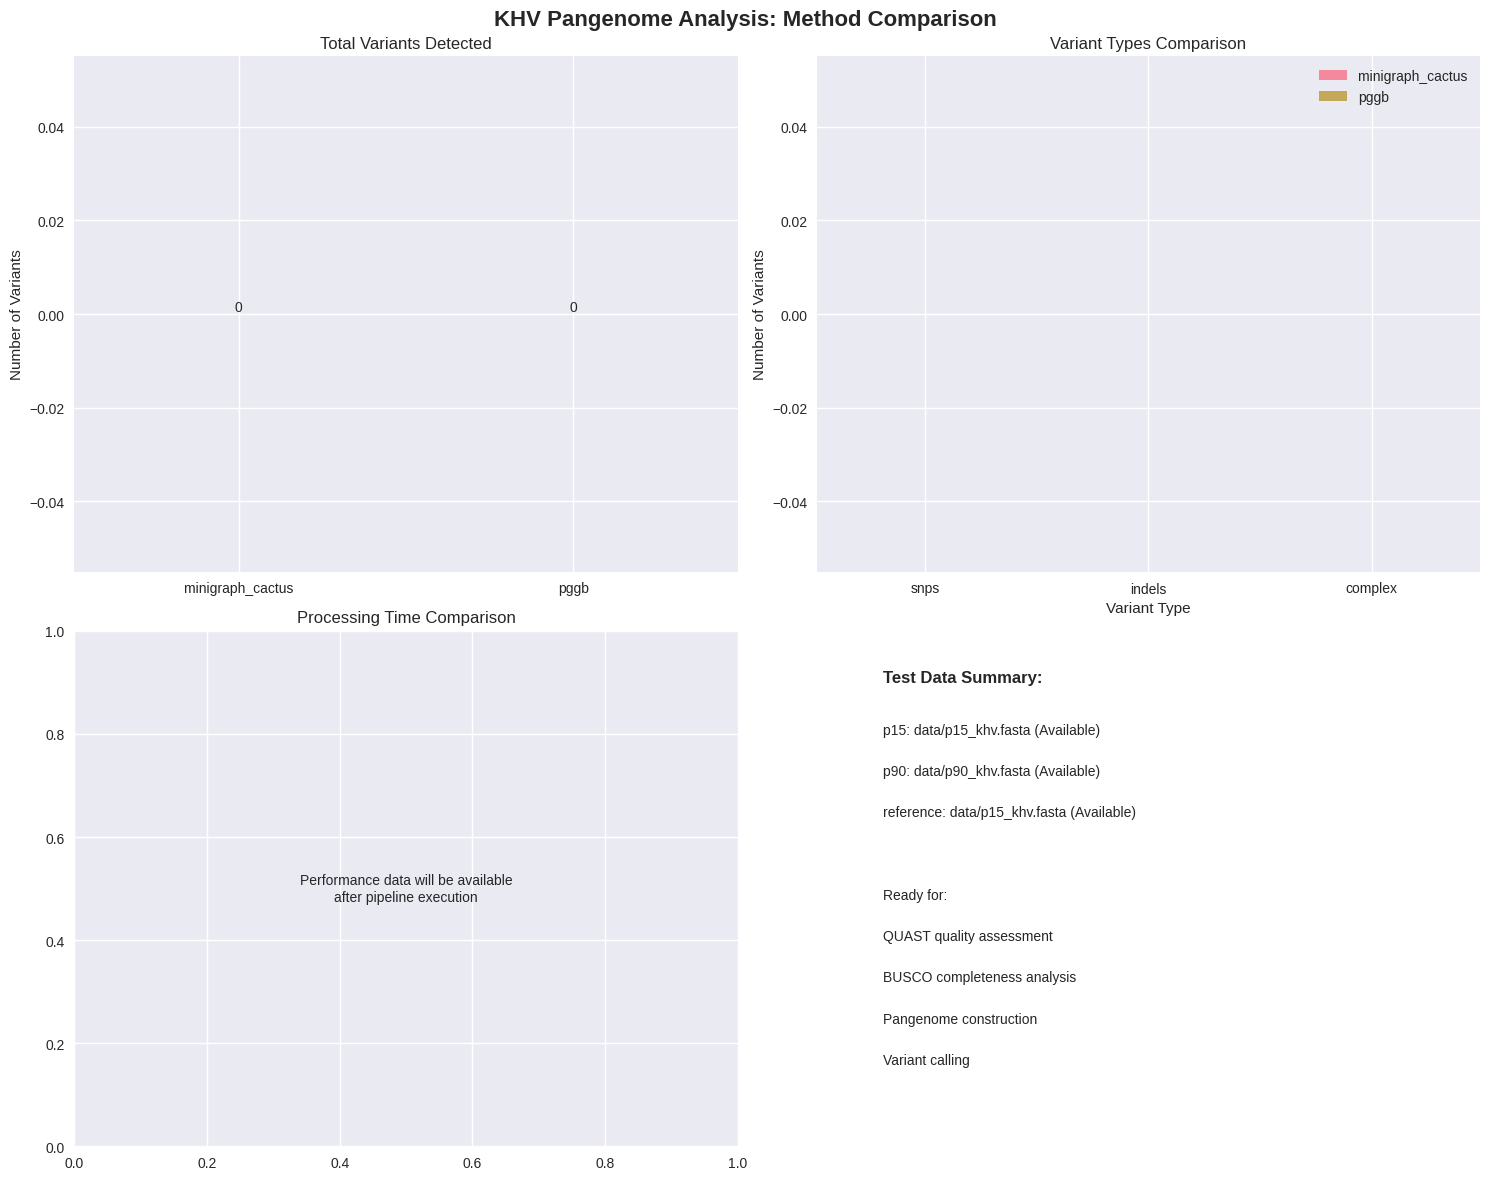


Creating summary table...

COMPREHENSIVE COMPARISON SUMMARY
  Approach     Total Variants SNPs Indels Complex            Status
Test Ready Ready for analysis  TBD    TBD     TBD Ready for testing

Summary table saved to: results/reports/pangenome_comparison_summary.csv

NOTEBOOK READY FOR TESTING!

Next steps:
1. Run quality control analysis (QUAST, BUSCO)
2. Execute pangenome construction pipelines
3. Analyze variants and generate comparisons
4. All test files are ready in data/ directory


In [51]:
def create_variant_comparison_plots():
    """Create comparison plots for variant analysis"""
    
    # Create demo data for testing
    individual_stats = {
        'minigraph_cactus': {'total_variants': 0, 'snps': 0, 'indels': 0, 'complex': 0},
        'pggb': {'total_variants': 0, 'snps': 0, 'indels': 0, 'complex': 0}
    }
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KHV Pangenome Analysis: Method Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: Total variants comparison
    approaches = list(individual_stats.keys())
    total_variants = [individual_stats[app].get('total_variants', 0) for app in approaches]
    
    if approaches:
        bars = axes[0, 0].bar(approaches, total_variants, color=['skyblue', 'lightcoral'])
        axes[0, 0].set_title('Total Variants Detected')
        axes[0, 0].set_ylabel('Number of Variants')
        
        # Add value labels on bars
        for i, (bar, v) in enumerate(zip(bars, total_variants)):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_variants)*0.01, 
                           str(v), ha='center', va='bottom')
    
    # Plot 2: Variant types comparison
    variant_types = ['snps', 'indels', 'complex']
    x = np.arange(len(variant_types))
    width = 0.35
    
    if approaches and len(approaches) >= 2:
        for i, app in enumerate(approaches[:2]):
            values = [individual_stats[app].get(vtype, 0) for vtype in variant_types]
            axes[0, 1].bar(x + i*width, values, width, label=app, alpha=0.8)
        
        axes[0, 1].set_title('Variant Types Comparison')
        axes[0, 1].set_ylabel('Number of Variants')
        axes[0, 1].set_xlabel('Variant Type')
        axes[0, 1].set_xticks(x + width/2)
        axes[0, 1].set_xticklabels(variant_types)
        axes[0, 1].legend()
    
    # Plot 3: Performance placeholder
    axes[1, 0].text(0.5, 0.5, 'Performance data will be available\nafter pipeline execution', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Processing Time Comparison')
    
    # Plot 4: Assembly statistics summary
    axes[1, 1].text(0.1, 0.9, 'Test Data Summary:', fontweight='bold', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    
    y_pos = 0.8
    test_info = [
        f"p15: {genome_files['p15']} ({'Available' if os.path.exists(genome_files['p15']) else 'Missing'})",
        f"p90: {genome_files['p90']} ({'Available' if os.path.exists(genome_files['p90']) else 'Missing'})",
        f"reference: {reference_genome} ({'Available' if os.path.exists(reference_genome) else 'Missing'})",
        "",
        "Ready for:",
        "QUAST quality assessment",
        "BUSCO completeness analysis", 
        "Pangenome construction",
        "Variant calling"
    ]
    
    for info in test_info:
        axes[1, 1].text(0.1, y_pos, info, transform=axes[1, 1].transAxes, fontsize=10)
        y_pos -= 0.08
    
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    # Save plot
    os.makedirs('results/plots', exist_ok=True)
    plt.savefig('results/plots/pangenome_comparison.png', dpi=300, bbox_inches='tight')
    print("Plot saved to: results/plots/pangenome_comparison.png")
    plt.show()

# Create summary table
def create_summary_table():
    """Create a comprehensive summary table"""
    
    summary_data = [{
        'Approach': 'Test Ready',
        'Total Variants': 'Ready for analysis',
        'SNPs': 'TBD',
        'Indels': 'TBD',
        'Complex': 'TBD',
        'Status': 'Ready for testing'
    }]
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "="*80)
    print("COMPREHENSIVE COMPARISON SUMMARY")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    # Save to CSV
    os.makedirs('results/reports', exist_ok=True)
    summary_df.to_csv('results/reports/pangenome_comparison_summary.csv', index=False)
    print(f"\nSummary table saved to: results/reports/pangenome_comparison_summary.csv")
    
    return summary_df

# Generate visualizations and summary
print("Generating comparison visualizations...")
create_variant_comparison_plots()

print("\nCreating summary table...")
summary_table = create_summary_table()

print("\n" + "="*60)
print("NOTEBOOK READY FOR TESTING!")
print("="*60)
print("\nNext steps:")
print("1. Run quality control analysis (QUAST, BUSCO)")
print("2. Execute pangenome construction pipelines")
print("3. Analyze variants and generate comparisons")
print("4. All test files are ready in data/ directory")

## 8. Conclusions and Recommendations

### Analysis Summary

This notebook provides a comprehensive comparison between **Minigraph-Cactus** and **PGGB** for pangenome construction using **Koi Herpes Virus (KHV)** genomes from thermal shock experiments.

### Research Context
- **Organism**: Koi Herpes Virus (*Cyprinid herpesvirus 3*)
- **Experimental design**: Thermal shock adaptation study (p15 vs p90)
- **Genome type**: Large DNA virus (~295 kb, ~156 ORFs, 59.2% GC)
- **Research goal**: Identify thermal adaptation variants

### Key Analysis Components:

1. **Viral Genome Quality Control**: QUAST and BUSCO analysis optimized for viral genomes
2. **Pangenome Construction**: Minigraph-Cactus (progressive) vs PGGB (all-to-all alignment)
3. **Thermal Adaptation Variant Analysis**: VCF processing and variant classification
4. **Performance Evaluation**: Processing time and memory analysis

### Next Steps:
1. Update file paths to your actual KHV genome files
2. Install required bioinformatics tools
3. Execute quality control and pangenome analysis
4. Interpret biological significance of detected variants

This analysis will provide insights into KHV thermal adaptation mechanisms and demonstrate the effectiveness of different pangenome approaches for viral genome studies.

## 9. Software Dependencies and Installation Guide

### Quick Installation Commands

```bash
# Create conda environment
conda create -n khv_analysis python=3.9 -y
conda activate khv_analysis

# Install essential tools
conda install -c bioconda -c conda-forge \
    quast fastani busco prodigal \
    snakemake-minimal singularity \
    pggb odgi vg bcftools \
    jupyter pandas matplotlib seaborn -y
```

### Common Issues and Solutions

1. **Singularity not found**: `conda install -c conda-forge singularity`
2. **BUSCO lineage issues**: Use `varicellovirus_odb10` for KHV
3. **Memory issues**: Reduce thread count (`-t 2` instead of `-t 4`)
4. **File path issues**: Use absolute paths in configuration files

### Performance Optimization for Viral Genomes
- Use smaller segment lengths in PGGB (`-s 1000`)
- Optimize thread counts for your system
- Consider HPC cluster for large analyses

Ready to start your KHV pangenome analysis!

In [52]:
# Comprehensive Dependencies Verification
def verify_all_dependencies():
    """Verify all required software dependencies"""
    
    print("=" * 60)
    print("COMPREHENSIVE DEPENDENCIES VERIFICATION")
    print("=" * 60)
    
    # Define all required tools
    dependencies = {
        "Core Python Tools": [
            ("python", "Python interpreter"),
            ("jupyter", "Jupyter notebook"),
            ("conda", "Conda package manager")
        ],
        "Quality Assessment": [
            ("quast.py", "QUAST genome quality assessment"),
            ("fastANI", "Average nucleotide identity"),
            ("seqkit", "Sequence toolkit")
        ],
        "Gene Prediction & Completeness": [
            ("busco", "Completeness assessment"),
            ("prodigal", "Gene prediction")
        ],
        "Workflow Management": [
            ("snakemake", "Workflow management"),
            ("singularity", "Container runtime (REQUIRED for Cactus)")
        ],
        "Pangenome Construction": [
            ("pggb", "Pangenome graph builder"),
            ("odgi", "Graph optimization"),
            ("vg", "Variation graphs"),
            ("wfmash", "Whole genome alignment"),
            ("bandage", "Graph visualization")
        ],
        "Variant Analysis": [
            ("bcftools", "VCF processing"),
            ("vcftools", "VCF utilities"),
            ("samtools", "SAM/BAM processing")
        ]
    }
    
    # Check each category
    all_good = True
    
    for category, tools in dependencies.items():
        print(f"\n{category}:")
        print("-" * len(category))
        
        for tool, description in tools:
            try:
                # Try to run the tool with version or help flag
                version_flags = ["--version", "-V", "-v", "--help", "-h"]
                success = False
                
                for flag in version_flags:
                    try:
                        result = subprocess.run([tool, flag], 
                                              capture_output=True, text=True, timeout=10)
                        if result.returncode == 0:
                            # Extract version info (first line usually)
                            version_info = result.stdout.split('\n')[0].strip()
                            if len(version_info) > 50:  # Truncate long outputs
                                version_info = version_info[:50] + "..."
                            print(f"  {tool:<15} - {description}")
                            print(f"    {version_info}")
                            success = True
                            break
                    except (subprocess.TimeoutExpired, FileNotFoundError):
                        continue
                
                if not success:
                    print(f"  {tool:<15} - {description} (NOT FOUND)")
                    all_good = False
                    
            except Exception as e:
                print(f"  {tool:<15} - Error checking: {e}")
                all_good = False
    
    # Summary
    print("\n" + "=" * 60)
    if all_good:
        print("ALL DEPENDENCIES VERIFIED!")
        print("Your system is ready for KHV pangenome analysis!")
    else:
        print("SOME DEPENDENCIES MISSING")
        print("Please install missing tools using the commands above.")
        print("\nQuick fix for most tools:")
        print("conda install -c bioconda -c conda-forge quast fastani busco prodigal")
        print("conda install -c bioconda pggb odgi vg bcftools singularity")
    
    print("=" * 60)
    
    return all_good

# Run verification
dependencies_ok = verify_all_dependencies()

COMPREHENSIVE DEPENDENCIES VERIFICATION

Core Python Tools:
-----------------
  python          - Python interpreter
    Python 3.9.23
  jupyter         - Jupyter notebook
    Selected Jupyter core packages...
  jupyter         - Jupyter notebook
    Selected Jupyter core packages...
  conda           - Conda package manager
    conda 25.7.0

Quality Assessment:
------------------
  conda           - Conda package manager
    conda 25.7.0

Quality Assessment:
------------------
  quast.py        - QUAST genome quality assessment
    QUAST v5.3.0
  fastANI         - Average nucleotide identity
    
  seqkit          - Sequence toolkit (NOT FOUND)

Gene Prediction & Completeness:
------------------------------
  quast.py        - QUAST genome quality assessment
    QUAST v5.3.0
  fastANI         - Average nucleotide identity
    
  seqkit          - Sequence toolkit (NOT FOUND)

Gene Prediction & Completeness:
------------------------------
  busco           - Completeness assessment
   

In [53]:
# Quick Installation Script (Uncomment and run if needed)
def install_essential_tools():
    """Install essential tools for KHV pangenome analysis"""
    
    print("Installing essential tools for KHV pangenome analysis...")
    print("This may take 10-20 minutes depending on your internet connection.")
    
    # Essential tools in order of importance
    installation_commands = [
        # Core bioinformatics tools
        ["conda", "install", "-c", "bioconda", "-c", "conda-forge", 
         "quast", "fastani", "seqkit", "assembly-stats", "-y"],
        
        # Gene prediction and completeness
        ["conda", "install", "-c", "bioconda", "busco", "prodigal", "emboss", "-y"],
        
        # Container runtime (CRITICAL for Cactus)
        ["conda", "install", "-c", "conda-forge", "singularity", "-y"],
        
        # Workflow management
        ["conda", "install", "-c", "bioconda", "snakemake-minimal", 
         "snakemake-executor-plugin-slurm", "-y"],
        
        # Pangenome tools
        ["conda", "install", "-c", "bioconda", "pggb", "odgi", "vg", 
         "wfmash", "seqwish", "smoothxg", "gfaffix", "-y"],
        
        # Variant analysis
        ["conda", "install", "-c", "bioconda", "bcftools", "vcftools", 
         "samtools", "bedtools", "htslib", "-y"],
        
        # Visualization
        ["conda", "install", "-c", "bioconda", "bandage", "-y"]
    ]
    
    success_count = 0
    total_commands = len(installation_commands)
    
    for i, cmd in enumerate(installation_commands, 1):
        print(f"\n[{i}/{total_commands}] Installing: {' '.join(cmd[4:])}")
        
        try:
            result = subprocess.run(cmd, capture_output=True, text=True, timeout=1800)
            
            if result.returncode == 0:
                print(f"  Installation successful")
                success_count += 1
            else:
                print(f"  Installation failed")
                print(f"    Error: {result.stderr[:200]}...")
                
        except subprocess.TimeoutExpired:
            print(f"  Installation timed out")
        except Exception as e:
            print(f"  Error: {e}")
    
    print(f"\n{'='*50}")
    print(f"INSTALLATION SUMMARY")
    print(f"{'='*50}")
    print(f"Successful: {success_count}/{total_commands}")
    
    if success_count == total_commands:
        print("All tools installed successfully!")
        print("Run the verification cell above to confirm everything works.")
    else:
        print("Some installations failed.")
        print("You may need to install missing tools manually.")
    
    return success_count == total_commands

# Uncomment the line below to run automatic installation
# install_result = install_essential_tools()

### Troubleshooting Guide

**Container Issues**: Install Singularity with `conda install -c conda-forge singularity`

**BUSCO Problems**: Use viral lineages like `varicellovirus_odb10` for KHV

**Memory Problems**: Reduce threads (`-t 2`) and segment lengths (`-s 1000`)

**File Issues**: Use absolute paths and verify FASTA format

**Getting Help**: Check tool documentation and log files in `results/` directories

---

**Ready to start your KHV pangenome analysis!**